In [6]:
import warnings
warnings.filterwarnings('ignore')

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Wildfire Satellite Detection

## Importing Libraries

In [7]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model

## Data Preparation

In [10]:
train_dir = '../datasets/kaggle/prediction/train'
valid_dir = '../datasets/kaggle/prediction/valid'
test_dir = '../datasets/kaggle/prediction/test'

In [11]:
datagen = ImageDataGenerator(rescale=1./255)

batch_size = 64
img_height, img_width = 224, 224  # ResNet50V2 expects 224x224 images

# Training data generator
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True
)

# Validation data generator
valid_generator = datagen.flow_from_directory(
    valid_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True
)

# Testing data generator
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

Found 30250 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.


## Data Viz

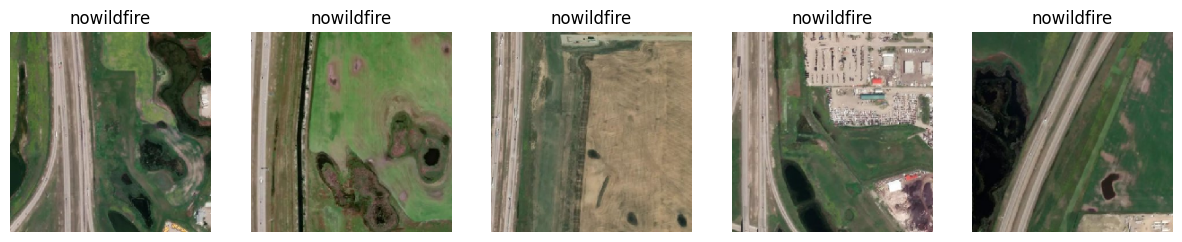

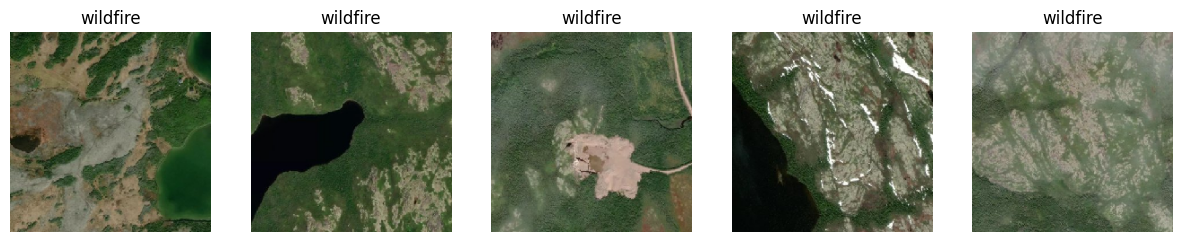

In [12]:
def plot_images(directory, category, num_images):
    category_dir = os.path.join(directory, category)
    images = os.listdir(category_dir)[:num_images]
    
    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(images):
        img_path = os.path.join(category_dir, img_name)
        img = load_img(img_path, target_size=(img_height, img_width))
        img_array = img_to_array(img) / 255.0
        
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img_array)
        plt.title(category)
        plt.axis('off')
    plt.show()

# Plotting 5 fire and 5 nofire images
plot_images(train_dir, 'nowildfire', 5)
plot_images(train_dir, 'wildfire', 5)

## Model Building

In [13]:
base_model = ResNet50V2(
    weights='imagenet', 
    include_top=False, 
    input_shape=(img_height, img_width, 3)
)

base_model.trainable = False

# Unfreeze the last few layers of the base model for fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 24,781,825 (94.54 MB)

 Trainable params: 4,631,297 (17.67 MB)

 Non-trainable params: 20,150,528 (76.87 MB)

In [14]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_activations=True,
    show_trainable=True
)

In [15]:
class PlotPredictionsCallback(tf.keras.callbacks.Callback):
    def __init__(self, valid_generator):
        self.valid_generator = valid_generator

    def on_epoch_end(self, epoch, logs=None):
        # Select a random image from the validation set
        valid_images, valid_labels = next(self.valid_generator)
        idx = np.random.randint(valid_images.shape[0])
        image = valid_images[idx]
        true_label = valid_labels[idx]

        # Predict the label
        prediction = self.model.predict(np.expand_dims(image, axis=0))[0][0]
        predicted_label = 'Fire' if prediction >= 0.5 else 'No Fire'
        true_label_text = 'Fire' if true_label == 1 else 'No Fire'

        # Plot the image with true and predicted labels
        plt.imshow(image)
        plt.title(f'True: {true_label_text}, Predicted: {predicted_label}')
        plt.axis('off')
        plt.show()

## Model Training

Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepstep - accuracy: 0.9088 - loss: 0.246


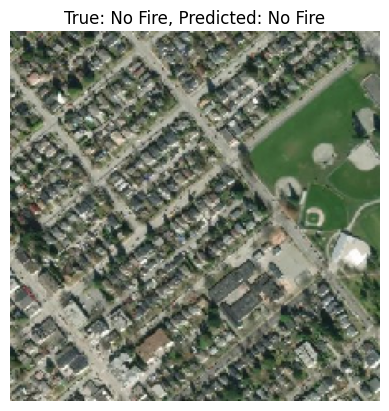

473/473 ━━━━━━━━━━━━━━━━━━━━ 1496s 3s/step - accuracy: 0.9089 - loss: 0.2462 - val_accuracy: 0.9617 - val_loss: 0.1099 - learning_rate: 0.0010
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/stepep - accuracy: 0.9632 - loss: 0.105


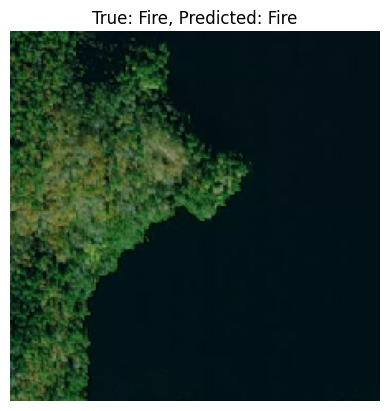

473/473 ━━━━━━━━━━━━━━━━━━━━ 1352s 3s/step - accuracy: 0.9632 - loss: 0.1051 - val_accuracy: 0.9676 - val_loss: 0.0982 - learning_rate: 0.0010
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/stepep - accuracy: 0.9773 - loss: 0.068


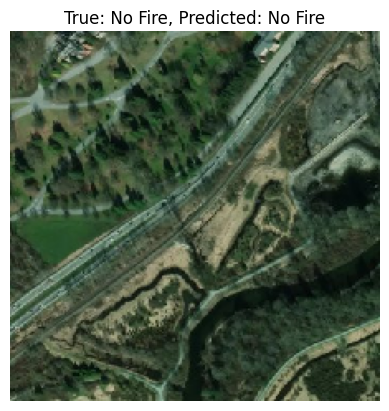

473/473 ━━━━━━━━━━━━━━━━━━━━ 1460s 3s/step - accuracy: 0.9773 - loss: 0.0685 - val_accuracy: 0.9673 - val_loss: 0.0964 - learning_rate: 0.0010
Epoch 4/5
  3/473 ━━━━━━━━━━━━━━━━━━━━ 21:48 3s/step - accuracy: 0.9575 - loss: 0.1557

In [ ]:
# Reduce learning rate when a metric has stopped improving
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    min_lr=1e-6
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

plot_predictions = PlotPredictionsCallback(valid_generator)

history = model.fit(
    train_generator,
    epochs=5,
    validation_data=valid_generator,
    callbacks=[early_stopping, lr_scheduler, plot_predictions]
)

## Model Evaluation

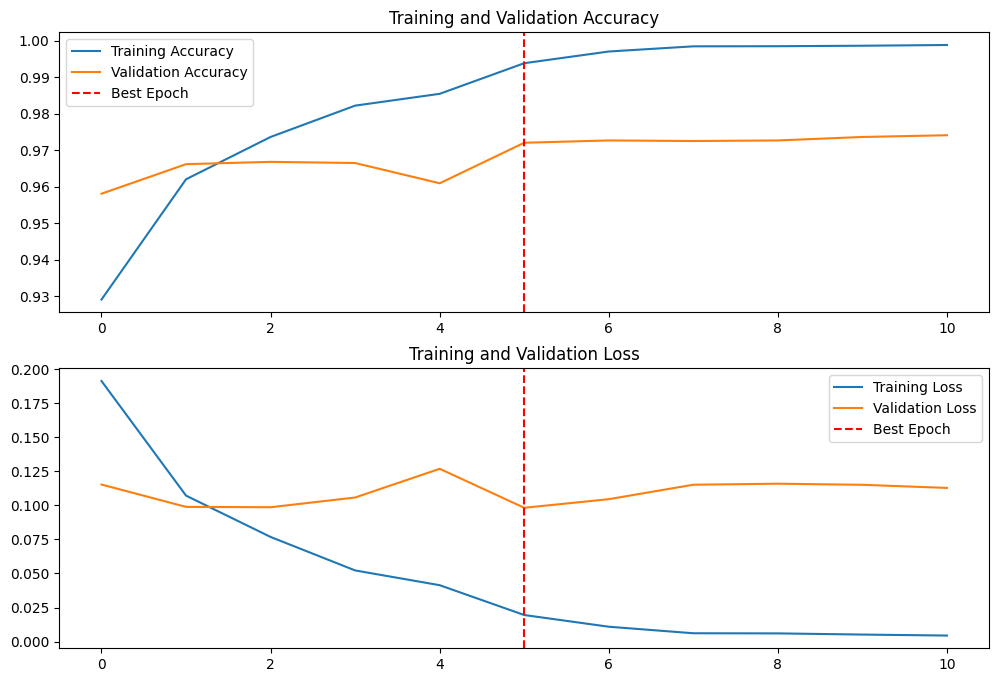

In [10]:
# Function to plot training history and highlight the best epoch
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    best_epoch = np.argmin(val_loss) + 1  # Adding 1 to match epoch numbering

    plt.figure(figsize=(12, 8))

    # Plot accuracy
    plt.subplot(2, 1, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.axvline(x=best_epoch-1, color='r', linestyle='--', label='Best Epoch')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(2, 1, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.axvline(x=best_epoch-1, color='r', linestyle='--', label='Best Epoch')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

plot_history(history)

In [11]:
all_test_images = []
all_test_labels = []

# Loop through the test_generator to get all images and labels
for images, labels in test_generator:
    all_test_images.extend(images)
    all_test_labels.extend(labels)
    if test_generator.batch_index == 0:  # Generator loops indefinitely, so we need to break
        break

all_test_images = np.array(all_test_images)
all_test_labels = np.array(all_test_labels)

In [12]:
# Make predictions on the entire test dataset
predictions = model.predict(all_test_images)
predicted_labels = (predictions >= 0.5).astype(int).flatten()

197/197 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step


In [13]:
# Calculate accuracy
accuracy = accuracy_score(all_test_labels, predicted_labels)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9783


In [14]:
# Classification report
report = classification_report(all_test_labels, predicted_labels, target_names=['No Fire', 'Fire'])
print(report)

              precision    recall  f1-score   support

     No Fire       0.97      0.98      0.98      2820
        Fire       0.99      0.97      0.98      3480

    accuracy                           0.98      6300
   macro avg       0.98      0.98      0.98      6300
weighted avg       0.98      0.98      0.98      6300



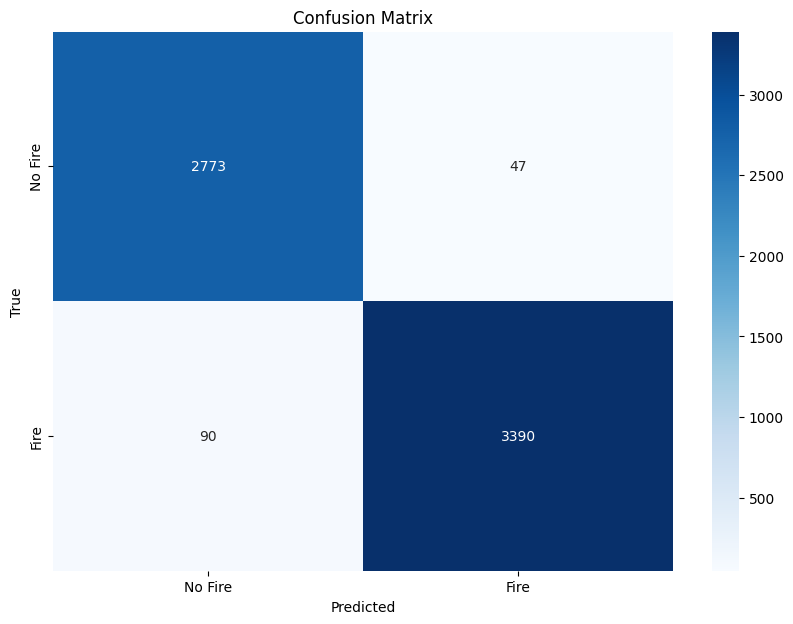

In [15]:
# Confusion matrix
cm = confusion_matrix(all_test_labels, predicted_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fire', 'Fire'], yticklabels=['No Fire', 'Fire'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

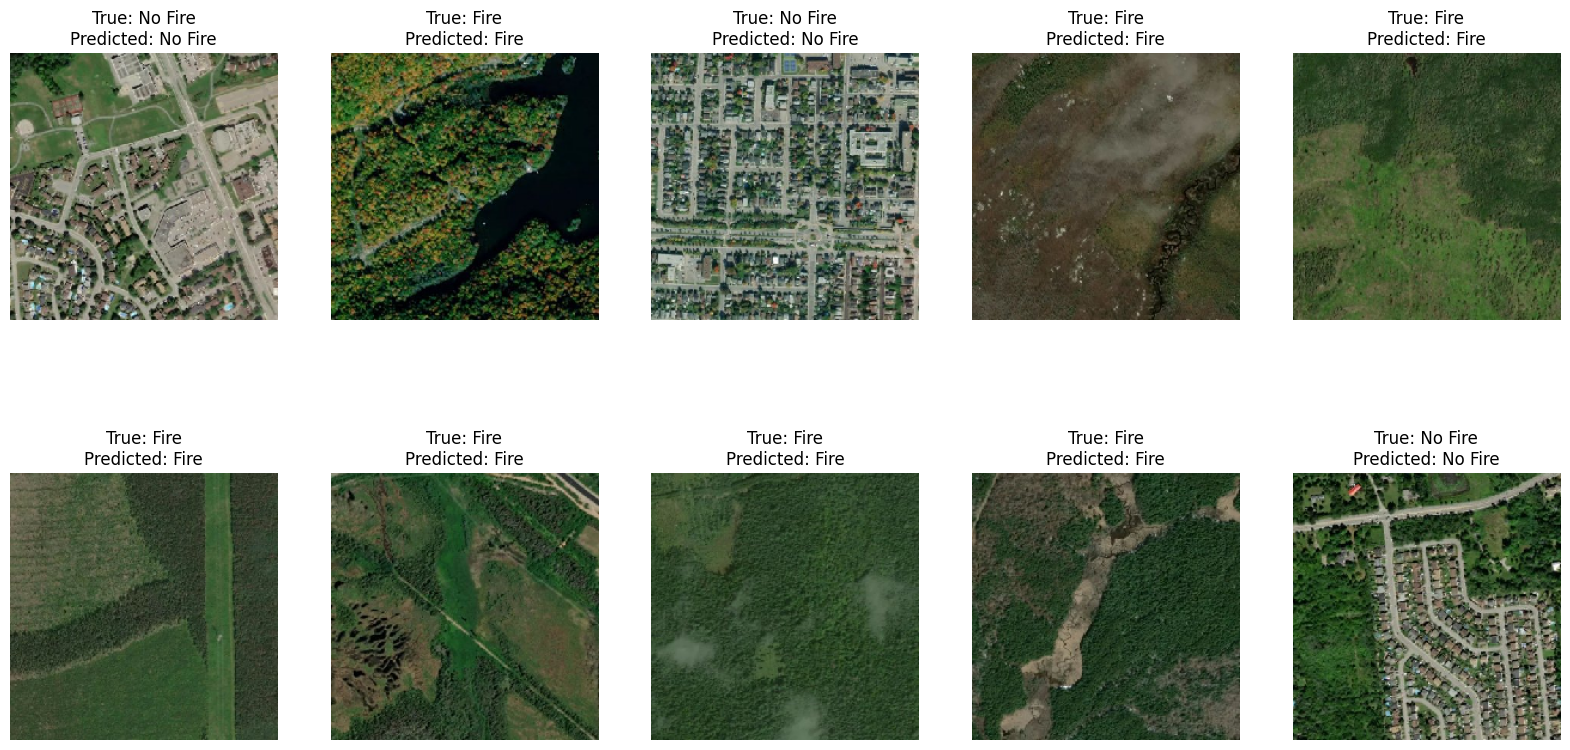

In [16]:
# Plot some test images with predictions
random_indices = np.random.choice(all_test_images.shape[0], 10, replace=False)

plt.figure(figsize=(20, 10))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i+1)
    plt.imshow(all_test_images[idx])
    true_label_text = 'Fire' if all_test_labels[idx] == 1 else 'No Fire'
    predicted_label_text = 'Fire' if predicted_labels[idx] == 1 else 'No Fire'
    plt.title(f'True: {true_label_text}\nPredicted: {predicted_label_text}')
    plt.axis('off')

plt.show()

In [17]:
# Save the trained model
model.save('wildfire_satellite_detection_model.keras')